In [2]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import glob
import config
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor
from utils.imgShow import imgShow
from matplotlib.colors import LinearSegmentedColormap


### Extract scenes footprint from .tif images in dataset.

In [3]:
# paths_truth = glob.glob(config.root_proj+'/data/dset/s1_truth/*.tif')
# paths_truth = sorted(paths_truth)
# names_truth = [os.path.basename(path) for path in paths_truth]
# scene_id = [name[0:7] for name in names_truth]  # get scenes id
# scene_id[0]


In [4]:
# ## extract scene footprint of the dset.
# fprint_wgs84 = []
# center_wgs84 = []
# for path in paths_truth:
#     img, img_info = readTiff(path)
#     lon_1, lon_2, lat_1, lat_2 = img_info['geoextent']
#     lon = [lon_1, lon_2, lon_2, lon_1, lon_1]
#     lat = [lat_1, lat_1, lat_2, lat_2, lat_1]
#     lon_wgs84, lat_wgs84 = coor2coor(srs_from=img_info['geosrs'], srs_to=4326, x=lon, y=lat)
#     fprint = Polygon(zip(lon_wgs84, lat_wgs84))
#     fprint_wgs84.append(fprint)

# print('number of footprints:',len(fprint_wgs84))


In [5]:
# # writh the data information to geopandas
# dic = {'scene_id': scene_id}
# df = pd.DataFrame(dic)
# fp_geodf = gpd.GeoDataFrame(df, geometry=fprint_wgs84, crs=4326)
# # fp_geodf.to_file(config.root_proj+'/data/dset/loc_vec/scene_footprint.shp') ## save the footprint file
# fp_geodf.head()


In [6]:
path_dset_fprint =  config.root_proj + '/data/dset/loc_vec/scene_footprint.shp'
path_tibet_boundry =  config.root_proj + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_tibet_dem =  config.root_proj + '/data/tibet/dem/tibet_SRTMGL3_down.tif'
path_tibet_dem_mask = config.root_proj + '/data/tibet/dem/tibet_SRTMGL3_down_mask.tif'
path_water_jrc = config.root_proj + '/data/tibet/jrc_water/tibet_water_jrc_500m.tif'



In [7]:
water_jrc, water_jrc_info= readTiff(path_water_jrc)
tibet_dem, tibet_dem_info = readTiff(path_tibet_dem)
tibet_dem_mask, tibet_dem_mask_info = readTiff(path_tibet_dem_mask)
tibet_dem_mask = np.ma.masked_where(tibet_dem_mask == 0, tibet_dem_mask)
print(tibet_dem_info['geoextent'])
print(water_jrc_info['geoextent'])


(73.49958333327572, 104.41958333326869, 26.000416666674386, 39.99041666667121)
(73.4955751387102, 104.42457037094532, 25.991405273072196, 39.991648976074934)


In [8]:
## extract scenes center coordinates of dataset
geodf_fp = gpd.read_file(path_dset_fprint)
coord_centers = []
for fprint in geodf_fp['geometry']:
    coord_centers += list(fprint.centroid.coords)
coord_centers = np.array(coord_centers)
coord_centers.shape
# coord_centers


(23, 2)

### Figure for study area

In [31]:
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["black", "white"])
cmap_water = LinearSegmentedColormap.from_list('linear color', ["white", "Blue"])


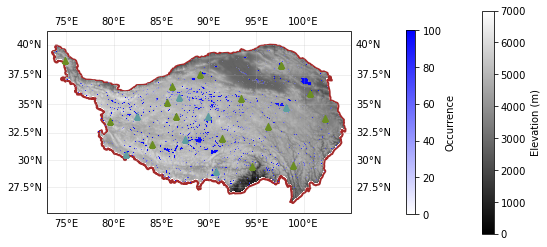

In [43]:
alpha_water = (water_jrc/100.0)[::-1,:]  ## !!!flip from y-axis

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([73, 105, 25.0, 40.0])
## 1. tibet boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='Brown', linewidth=2, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

## 2. dem image
ax_dem = ax.imshow(tibet_dem_mask, extent=tibet_dem_mask_info['geoextent'], 
                          vmin=0, vmax=7000, cmap=cmap_dem, transform=ccrs.PlateCarree(), zorder=1)  # cmap:PRGn
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, zorder=1)

## 3. water map
ax_water = ax.imshow(water_jrc, extent=water_jrc_info['geoextent'], \
                                vmin=0, vmax=100, alpha=alpha_water, interpolation='none', \
                                cmap=cmap_water, transform=ccrs.PlateCarree(), zorder=1)

## 4. scene samples
ax.scatter(coord_centers[0:7,0], coord_centers[0:7,1], color='CadetBlue', \
                                marker='^', s=40, alpha=1, transform=ccrs.PlateCarree(), zorder=2)
ax.scatter(coord_centers[7:,0], coord_centers[7:,1], color='OliveDrab', \
                                marker='^', s=40, alpha=1, transform=ccrs.PlateCarree(), zorder=2)

plt.colorbar(ax_dem, fraction=0.025, pad=0.15, label='Elevation (m)')  #
plt.colorbar(ax_water, fraction=0.025, pad=0.15, label='Occurrence')   #



### Sub-figure for study area

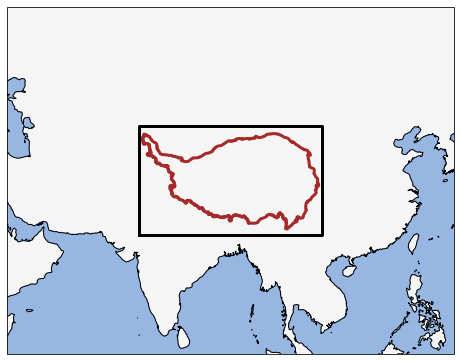

In [10]:
region_x = [73, 105, 105, 73, 73]
region_y = [25, 25, 41, 41, 25]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
# ax.stock_img()
ax.add_feature(cfeature.LAND, facecolor='WhiteSmoke')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE, edgecolor='Black')
ax.set_extent([50, 128, 5, 48.0])
# ax.gridlines(draw_labels=True,linewidth=0)
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                                crs=ccrs.PlateCarree(), linewidth=3, edgecolor='Brown', facecolor='none')
ax.add_feature(shp_fea, zorder=1)
# ax.gridlines(draw_labels=False)
plt.plot(region_x, region_y, transform=ccrs.PlateCarree(), linewidth=3, color='black')
